In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import uproot
from hep_ml import reweight
from matplotlib import pyplot as plt

In [4]:
columns = ['hSPD', 'pt_b', 'pt_phi', 'vchi2_b', 'mu_pt_sum']

with uproot.open('MC_distribution.root',
                            httpsource={'chunkbytes': 1024*1024, 'limitbytes': 33554432, 'parallel': 64}
                            ) as original_file:
    original_tree = original_file['tree']
    original = original_tree.arrays(library='pd')
with uproot.open('RD_distribution.root',
                          httpsource={'chunkbytes': 1024*1024, 'limitbytes': 33554432, 'parallel': 64}
                          ) as target_file:
    target_tree = target_file['tree']
    target = target_tree.arrays(library='pd')
original_weights = np.ones(len(original))

In [5]:
from sklearn.model_selection import train_test_split

# divide original samples into training ant test parts
original_train, original_test = train_test_split(original)
# divide target samples into training ant test parts
target_train, target_test = train_test_split(target)

original_weights_train = np.ones(len(original_train))
original_weights_test = np.ones(len(original_test))

In [6]:
from hep_ml.metrics_utils import ks_2samp_weighted

hist_settings = {'bins': 100, 'density': True, 'alpha': 0.7}


def draw_distributions(original, target, new_original_weights):
    plt.figure(figsize=[15, 7])
    for id, column in enumerate(columns, 1):
        xlim = np.percentile(np.hstack([target[column]]), [0.01, 99.99])
        plt.subplot(2, 3, id)
        plt.hist(original[column], weights=new_original_weights, range=xlim, **hist_settings)
        plt.hist(target[column], range=xlim, **hist_settings)
        plt.title(column)
        print('KS over ', column, ' = ', ks_2samp_weighted(original[column], target[column],
                                         weights1=new_original_weights, weights2=np.ones(len(target), dtype=float)))

In [7]:
# pay attention, actually we have very few data
len(original), len(target)

(1000000, 21441)

KS over  hSPD  =  0.5203540728277889
KS over  pt_b  =  0.21639364439970188
KS over  pt_phi  =  0.4020113592414034
KS over  vchi2_b  =  0.40466385087324064
KS over  mu_pt_sum  =  0.21639364439970188


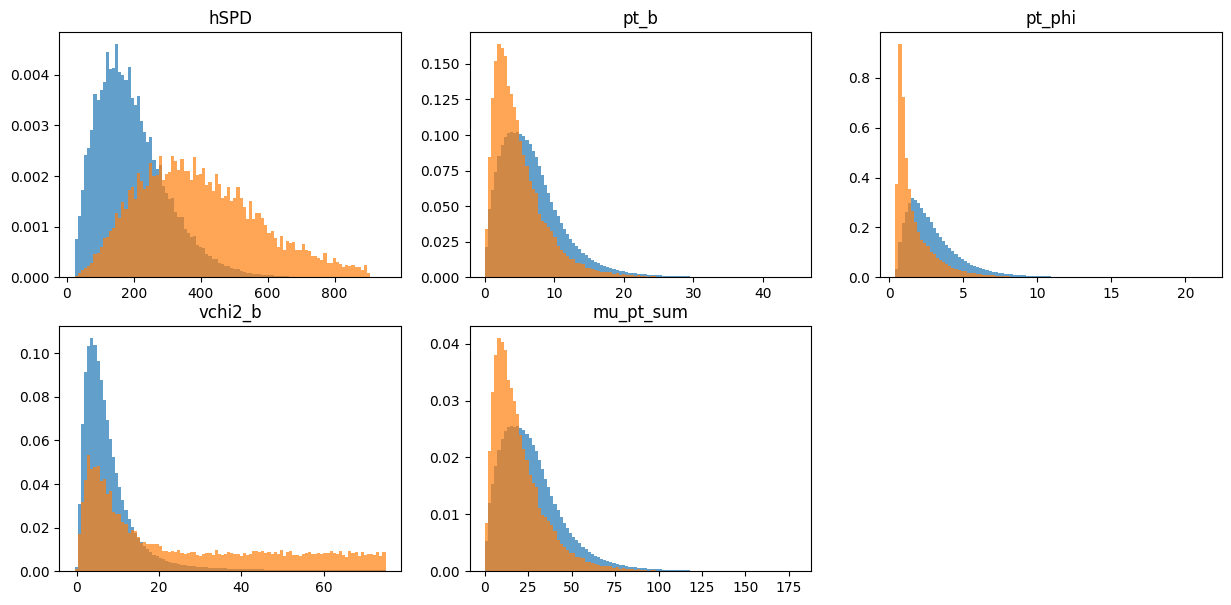

In [8]:
draw_distributions(original, target, original_weights)

KS over  hSPD  =  0.5192109452736213
KS over  pt_b  =  0.21704732338171845
KS over  pt_phi  =  0.39966391044788385
KS over  vchi2_b  =  0.40514707462065974
KS over  mu_pt_sum  =  0.21704732338171845


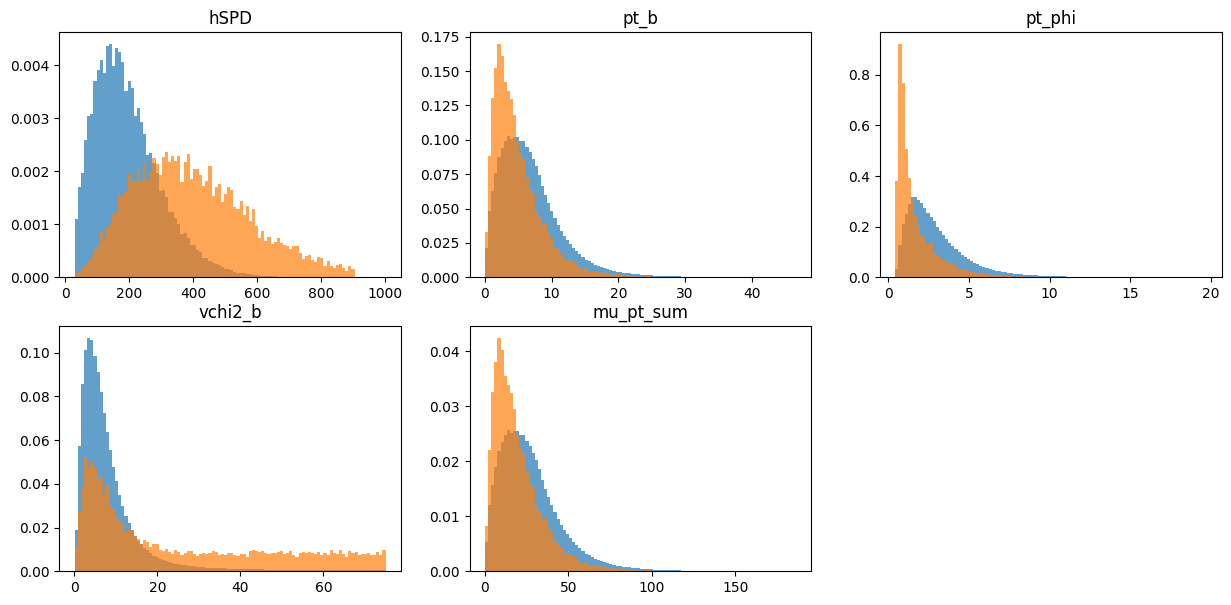

In [9]:
draw_distributions(original_train, target_train, original_weights_train)

KS over  hSPD  =  0.5257125174407868
KS over  pt_b  =  0.21999048050702263
KS over  pt_phi  =  0.4106600369332888
KS over  vchi2_b  =  0.40507566610785833
KS over  mu_pt_sum  =  0.21999048050702263


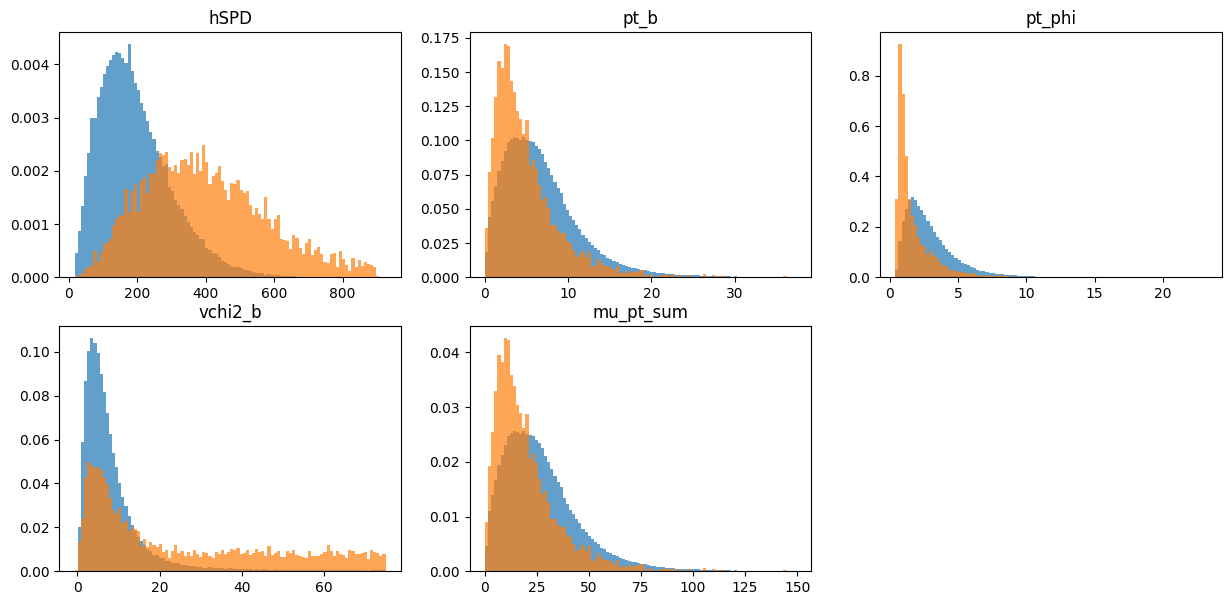

In [10]:
draw_distributions(original_test, target_test, original_weights_test)

KS over  hSPD  =  0.41668879942361337
KS over  pt_b  =  0.12155807010067154
KS over  pt_phi  =  0.28881780935856255
KS over  vchi2_b  =  0.3457906333465782
KS over  mu_pt_sum  =  0.12155807010067154


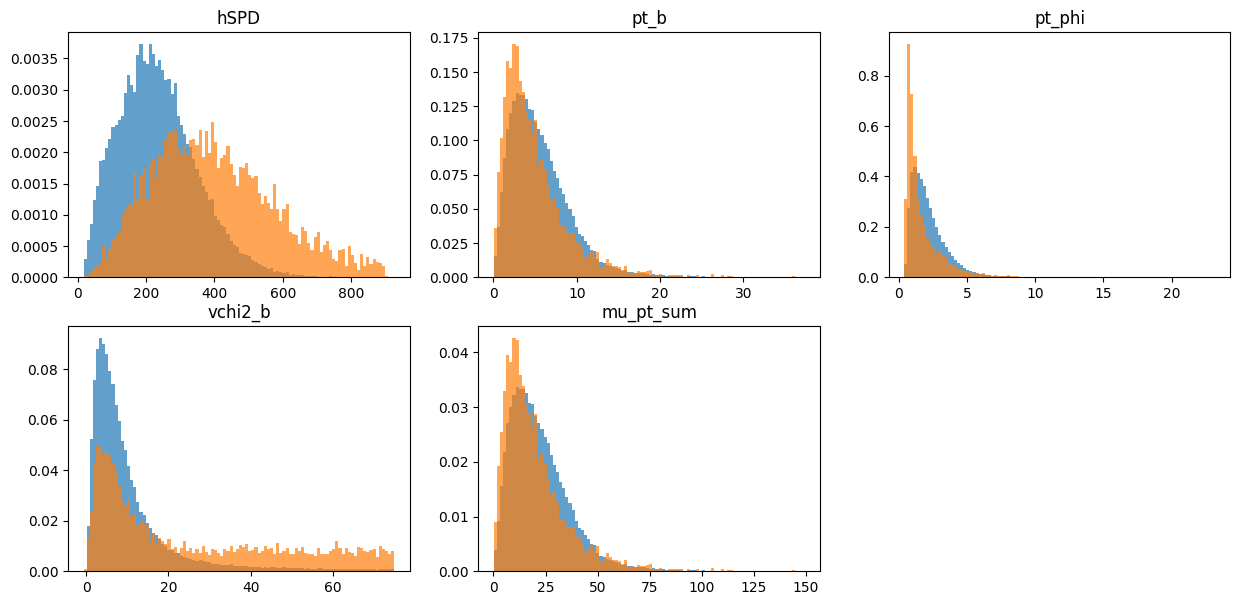

In [11]:
bins_reweighter = reweight.BinsReweighter(n_bins=20, n_neighs=1.)
bins_reweighter.fit(original_train, target_train)

bins_weights_test = bins_reweighter.predict_weights(original_test)
# validate reweighting rule on the test part comparing 1d projections
draw_distributions(original_test, target_test, bins_weights_test)

KS over  hSPD  =  0.032080860542282874
KS over  pt_b  =  0.020290564630492336
KS over  pt_phi  =  0.03111752290805423
KS over  vchi2_b  =  0.028776930302585102
KS over  mu_pt_sum  =  0.020290564630492336


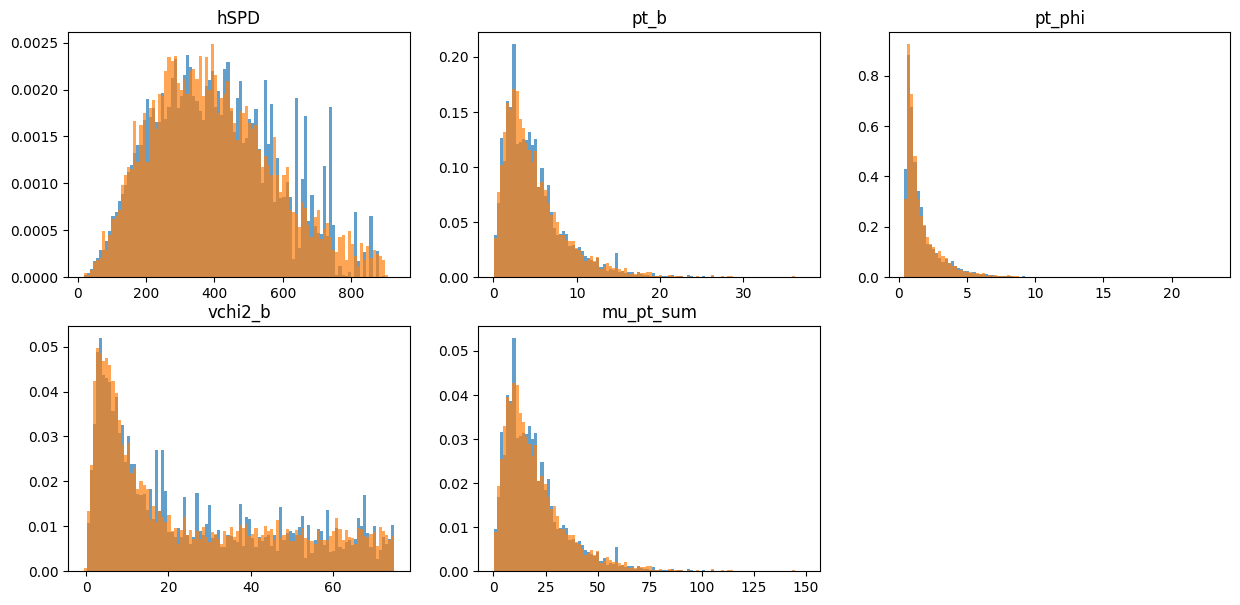

In [12]:
reweighter = reweight.GBReweighter(n_estimators=250, learning_rate=0.1, max_depth=3, min_samples_leaf=1000,
                                   gb_args={'subsample': 0.4})
reweighter.fit(original_train, target_train)

gb_weights_test = reweighter.predict_weights(original_test)
# validate reweighting rule on the test part comparing 1d projections
draw_distributions(original_test, target_test, gb_weights_test)

In [13]:
def check_ks_of_expression(expression):
    col_original = original_test.eval(expression, engine='python')
    col_target = target_test.eval(expression, engine='python')
    w_target = np.ones(len(col_target), dtype='float')
    print('No reweight   KS:', ks_2samp_weighted(col_original, col_target,
                                                 weights1=original_weights_test, weights2=w_target))
    print('Bins reweight KS:', ks_2samp_weighted(col_original, col_target,
                                                 weights1=bins_weights_test, weights2=w_target))
    print('GB Reweight   KS:', ks_2samp_weighted(col_original, col_target,
                                                 weights1=gb_weights_test, weights2=w_target))

In [14]:
check_ks_of_expression('hSPD')

No reweight   KS: 0.5257125174407868
Bins reweight KS: 0.41668879942361337
GB Reweight   KS: 0.032080860542282874


In [15]:
check_ks_of_expression('hSPD * pt_phi')

No reweight   KS: 0.09482123223296196
Bins reweight KS: 0.12030486161863968
GB Reweight   KS: 0.01665905937195794


In [16]:
check_ks_of_expression('hSPD * pt_phi * vchi2_b')

No reweight   KS: 0.3664187700062685
Bins reweight KS: 0.3329424003195916
GB Reweight   KS: 0.02400175468055929


In [17]:
check_ks_of_expression('pt_b * pt_phi / hSPD ')

No reweight   KS: 0.48753692408121485
Bins reweight KS: 0.3862437301033737
GB Reweight   KS: 0.02880728599861343


In [18]:
check_ks_of_expression('hSPD * pt_b * vchi2_b / pt_phi')

No reweight   KS: 0.49688256631301436
Bins reweight KS: 0.40420163237755263
GB Reweight   KS: 0.03514535137410191


In [19]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

data = np.concatenate([original_test, target_test])
labels = np.array([0] * len(original_test) + [1] * len(target_test))

weights = {}
weights['original'] = original_weights_test
weights['bins'] = bins_weights_test
weights['gb_weights'] = gb_weights_test


for name, new_weights in weights.items():
    W = np.concatenate([new_weights / new_weights.sum() * len(target_test), [1] * len(target_test)])
    Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.51)
    clf = GradientBoostingClassifier(subsample=0.3, n_estimators=50).fit(Xtr, Ytr, sample_weight=Wtr)

    print(name, roc_auc_score(Yts, clf.predict_proba(Xts)[:, 1], sample_weight=Wts))

original 0.9379652597139676
bins 0.9133578670531983
gb_weights 0.5014624575183515


Text(0.5, 1.0, 'predicted weights')

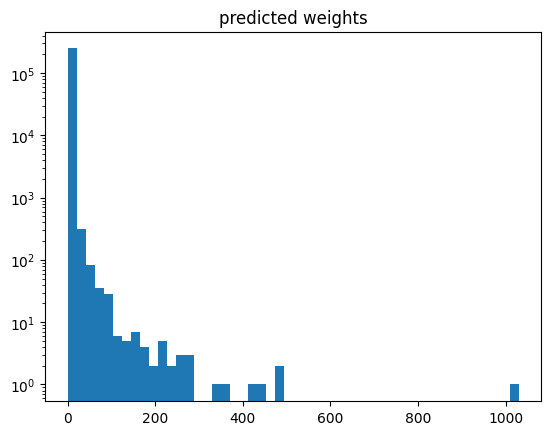

In [20]:
plt.hist(weights['gb_weights'], bins=50)
plt.yscale('log')
plt.title('predicted weights')

In [21]:
np.max(weights['gb_weights']), np.sum(weights['gb_weights'])

(1029.3134037186123, 71308.13009010843)

KFold prediction using folds column
KS over  hSPD  =  0.30780875942149843
KS over  pt_b  =  0.1807672676466292
KS over  pt_phi  =  0.30775680784089315
KS over  vchi2_b  =  0.2986183280333885
KS over  mu_pt_sum  =  0.1807672676466292


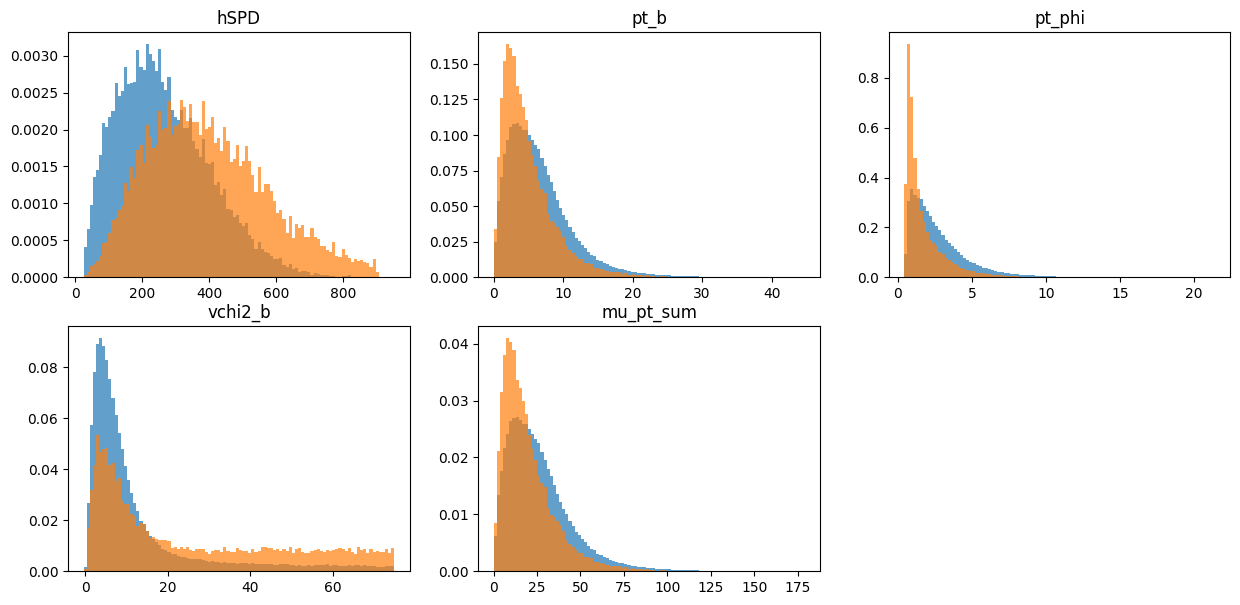

In [22]:
# define base reweighter
reweighter_base = reweight.GBReweighter(n_estimators=80,
                                        learning_rate=0.01, max_depth=4, min_samples_leaf=100,
                                        gb_args={'subsample': 0.8})
reweighter = reweight.FoldingReweighter(reweighter_base, n_folds=2)
# it is not needed divide data into train/test parts; reweighter can be train on the whole samples
reweighter.fit(original, target)

# predict method provides unbiased weights prediction for the whole sample
# folding reweighter contains two reweighters, each is trained on one half of samples
# during predictions each reweighter predicts another half of samples not used in training
folding_weights = reweighter.predict_weights(original)

draw_distributions(original, target, folding_weights)

In [23]:
data = np.concatenate([original, target])
labels = np.array([0] * len(original) + [1] * len(target))

weights = {}
weights['original'] = original_weights
weights['2-folding'] = folding_weights


for name, new_weights in weights.items():
    W = np.concatenate([new_weights / new_weights.sum() * len(target), [1] * len(target)])
    Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.51)
    clf = GradientBoostingClassifier(subsample=0.6, n_estimators=30).fit(Xtr, Ytr, sample_weight=Wtr)

    print(name, roc_auc_score(Yts, clf.predict_proba(Xts)[:, 1], sample_weight=Wts))

original 0.9369457018598477
2-folding 0.8261581269349237


Text(0.5, 1.0, 'predicted weights')

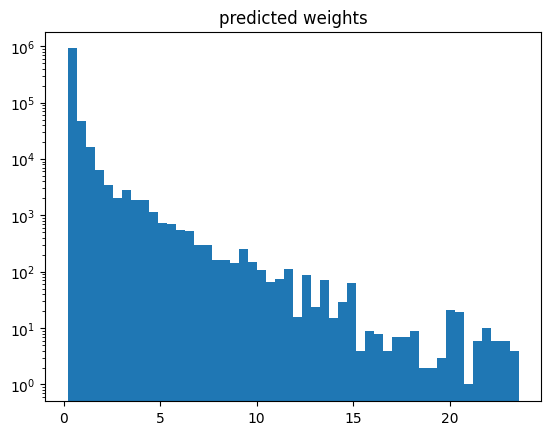

In [24]:
plt.hist(weights['2-folding'], bins=50)
plt.yscale('log')
plt.title('predicted weights')